In [1]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

In [3]:
#[256x256] -> [256x256] --- Generator ----> learns to generator -------> Squared Loss
#Discriminator ------> What class it is? -> Classifier Supervision ---> Discriminator Loss

In [4]:
#import packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import pandas as pd

In [5]:
print(tf.__version__)

2.15.0


In [6]:
TRAIN_BUF = 60000
BATCH_SIZE = 512
TEST_BUF = 10000
DIMS = (28,28,1) #->[784] -> flattened Linear | [28x28] -> Conv2D
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [7]:
28*28

784

In [8]:
(train_images, _), (test_images,_) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0],28,28,1).astype('float32') / 255.0

4422102/4422102 [==============================] - 1s 0us/step


In [9]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE))

In [10]:
7*7*64

3136

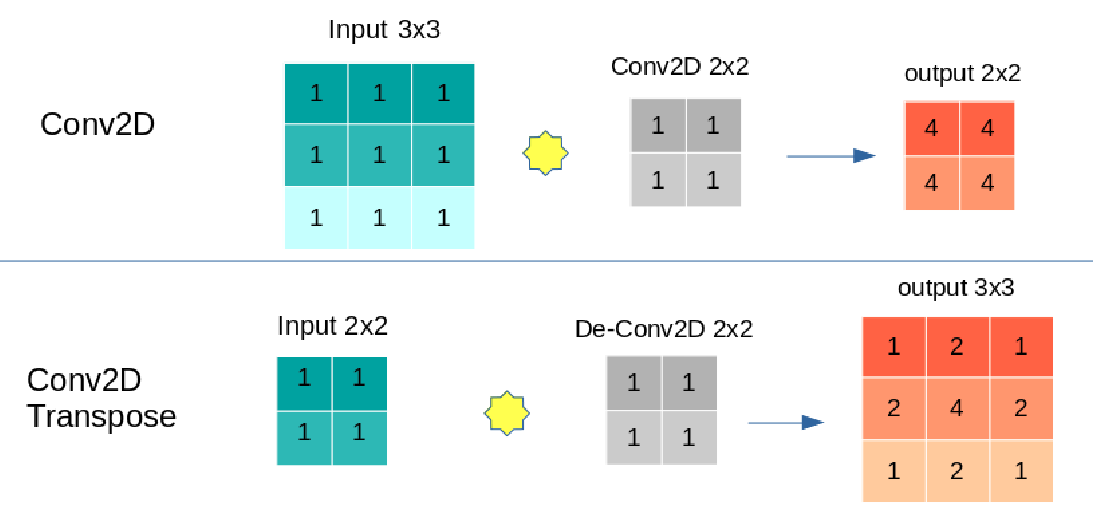

In [11]:
N_z = 64
#Conv2DTranspose - will have upsampling, to generate output feature map that has spatial dimensions greater than that of I/P
generator = [
    tf.keras.layers.Dense(units = 7*7*64, activation = 'relu'),
    tf.keras.layers.Reshape(target_shape = (7,7,64)),
    tf.keras.layers.Conv2DTranspose(filters = 64,kernel_size = 3, strides = (2,2),padding = "SAME",activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters = 32,kernel_size = 3, strides = (2,2),padding = "SAME",activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters = 1,kernel_size = 3, strides = (1,1),padding = "SAME",activation='sigmoid'),
]

#Loss - Discrimination Loss
discriminator = [
    tf.keras.layers.InputLayer(input_shape = DIMS),
    tf.keras.layers.Conv2D(filters=32,kernel_size = 3, strides = (2,2),activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size = 3, strides = (2,2),activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 1, activation= None)
]

In [12]:
class GAN(tf.keras.Model):
  #Extends tf.keras.Models
  def __init__(self, **kwargs):
    super(GAN,self).__init__()
    self.__dict__.update(kwargs)

    self.gen = tf.keras.Sequential(self.gen)
    self.disc = tf.keras.Sequential(self.disc)

  def generate(self, z):
    return self.gen(z)

  def discriminate(self,x):
    return self.disc(x)

  def compute_loss(self, x):
    #Generate noise from a normal distribution
    z_sample = tf.random.normal([x.shape[0],1,1,self.n_z])

    #Run the noise throught the generator
    x_gen = self.generate(z_sample)

    #Disctimnate x and x_gen
    logits_x = self.discriminate(x)
    logits_x_gen = self.discriminate(x_gen)

    ##Losses
    #loss of real label "1"
    disc_real_loss = gan_loss(logits = logits_x,is_real = True) #512,1
    #loss of real label "0"
    disc_fake_loss = gan_loss(logits = logits_x_gen, is_real = False)
    disc_loss = disc_real_loss+disc_fake_loss

    #loss of fake label with 1
    gen_loss = gan_loss(logits = logits_x_gen, is_real = True)
    return disc_loss, gen_loss

  def compute_gradients(self, x):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      disc_loss, gen_loss = self.compute_loss(x)

    gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
    return gen_gradients, disc_gradients

  def apply_gradients(self, gen_gradients, disc_gradients):
    self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
    self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))

  @tf.function
  def train(self, train_x):
    gen_gradients, disc_gradients = self.compute_gradients(train_x)
    self.apply_gradients(gen_gradients, disc_gradients)

def gan_loss(logits, is_real = True):
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)

  return tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels = labels, logits = logits)

In [13]:
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1 = 0.5)
disc_optmizer = tf.keras.optimizers.RMSprop(0.005)

#model
model = GAN(gen = generator, disc = discriminator,gen_optimizer = gen_optimizer,disc_optimizer = disc_optmizer, n_z = N_z)

In [17]:
def plot_reconstruction(model, nex = 8, zm=2):
  samples = model.generate(tf.random.normal(shape= (BATCH_SIZE, N_z)))
  fig,axis = plt.subplots(ncols = nex, nrows = 1, figsize=(zm*nex, zm))
  for axi in range(nex):
    axis[axi].matshow(samples.numpy()[axi].squeeze(), cmap = plt.cm.Greys, vmin = 0, vmax=1)
    axis[axi].axis('off')
  plt.show()

In [18]:
losses = pd.DataFrame(columns = ['disc_loss','gen_loss'])

Epoch 99 | disc_loss 0.854658842086792 | gen_loss 1.4791693687438965


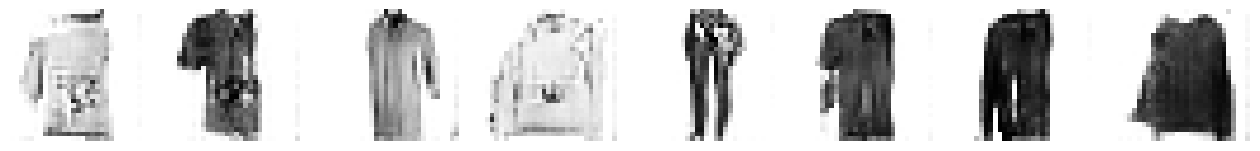

In [19]:
from tqdm import tqdm
n_epochs = 100
for epoch in range(n_epochs):
  for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES),train_dataset), total = N_TRAIN_BATCHES):
    model.train(train_x)
  loss= []
  for batch, text_x in tqdm(zip(range(N_TEST_BATCHES),test_dataset), total = N_TEST_BATCHES):
    loss.append(model.compute_loss(train_x))
  losses.loc[len(losses)] = np.mean(loss, axis = 0)
  display.clear_output()
  print("Epoch {} | disc_loss {} | gen_loss {}".format(epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]))
  plot_reconstruction(model)

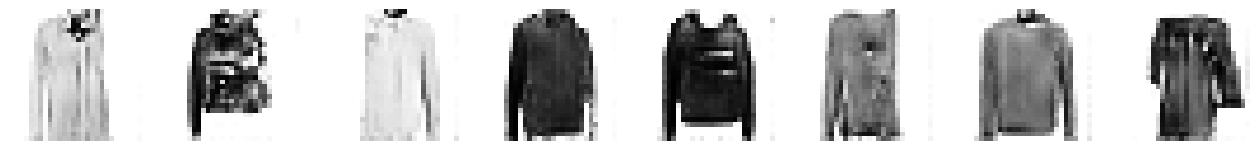

In [22]:
plot_reconstruction(model)

In [ ]:
#FSL - Few Shot Learning - Transfer Learning